<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_ML/blob/main/notebooks/Modele_Logistique_regression%20Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a***Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local***  
il est possible que google colab vous demande re demarrer la session

In [ ]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_ML.git

fatal: destination path 'Rakuten_Text_Classification_ML' already exists and is not an empty directory.



***Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires***  
You must restart the runtime in order to use newly installed versions

In [ ]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_ML/src')

!pip install -r /content/Rakuten_Text_Classification_ML/requirements.txt

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.regexp import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
# set the max columns to none
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import configparser
import sys
sys.path.append('../src')
#sys.path.append('/content/Rakuten_Text_Classification_ML/src')
import Bibli_DataScience_3_1 as ds
config = configparser.ConfigParser()
#config.read('Rakuten_config_colab.ini')
config.read('Rakuten_config.ini')

section :  ['DOSSIER', 'FICHIER']


[]

In [ ]:
import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')
df_feats['PAYS_LANGUE'] = df['PAYS_LANGUE']


Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()


In [ ]:
df_feats

,Unnamed: 0,designation,description,productid,imageid,PAYS_LANGUE
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,de
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,ca
...,...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734,en
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,fr
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,fr
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,fr


In [ ]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


*préprocessing utilisé :*
 1. concaténation des champs "désignation" et "description"
 2. traitement des phrases avec une expression régulière :  `r = re.compile(r"[a-zA-Z0-9âéè°]{2,}")`  
	 on ne garde	que certains caractères et les mots d'au moins 2 caractères
 3.  on découpe chaque phrase en une liste de mots : word_tokenize
 4.  on met tous les mots de la phrase en minuscule
 5.  on retire les stopswords par langue en utilisant le module nltk.corpus

In [ ]:
def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['design_descrip'] = df_feats.apply(combine_description_and_designation, axis=1)

In [ ]:
def clean_sentence(sentence,langue):
        if langue == 'en':
            SW = stopwords.words('english')
        elif langue == 'fr':
            SW = stopwords.words('french')
        elif langue == 'de':
            SW = stopwords.words('german')
        elif langue == 'ca':
            SW = stopwords.words('french')
        elif langue == 'nl':
            SW = stopwords.words('dutch')
        elif langue == 'it':
            SW = stopwords.words('italian')
        elif langue == 'es':
            SW = stopwords.words('spanish')
        else:
            SW = stopwords.words('french')
         # Pour chaque mot de la phrase (dans l'ordre inverse)
        for i, word in reversed(list(enumerate(sentence))):
                # Si le mot est un stopword
                if word in SW :
                    # On l'enlève de l'artikle
                    sentence.pop(i)
        return sentence
def dictionarize(article,langue):
        r = re.compile(r"[a-zA-Z0-9âéè°]{2,}")
        #dico ={}
        ListMots =[]
        sent = ' '.join(r.findall(article))
        ## Etape 3: Découper chaque phrase en une liste de mots
        sent = word_tokenize(sent)
        ## Etape 4: Mettre tous les mots de la phrase en minuscule
        sent_lower = [word.lower() for word in sent]
        ## Etape 5: Retirer les stopwords de chaque liste.
        sent_clean = clean_sentence(sent_lower,langue)
        #dico[i]=sent_clean
        ListMots.append(sent_clean)
        resultat = []

        for sous_liste in ListMots:
            resultat.extend(sous_liste)

        return resultat
def decomposition(article,langue):

        artikle = dictionarize(article,langue)
        artikle = [mot for mot in artikle if mot not in stop_words]

        return artikle

In [ ]:
df_feats['phrases'] = df_feats.apply(lambda x :decomposition(str(x.design_descrip),str(x.PAYS_LANGUE)), axis=1)

## 1er test : LogisticRegression(max_iter) sans paramètres excepté max_iter (afin d'eviter un warning)

In [ ]:

X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle LogisticRegression
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', LogisticRegression(max_iter=300)),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)


F1 Score:  0.8030677959713491
Accuracy:  0.802269564286479


**max_iter =  300**
F1 Score:  0.8030138417578072
Accuracy:  0.8022160368268922

**max_iter =  500**
F1 Score:  0.8030138417578072
Accuracy:  0.8022160368268922

**max_iter =  1000**
F1 Score:  0.8030138417578072
Accuracy:  0.8022160368268922

## Grille de recherche  
Recherches des paramètres optimaux :   
**grille**  = {
   'C': [0.1, 1, 10],
    'max_iter': [200,300],
    'solver':['lbfgs','liblinear'],
    'penalty': ['l1', 'l2','elasticnet',None] }

In [ ]:

X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', LogisticRegression(max_iter=300)),
])

parametres = {
   'clf__C': [0.1, 1, 10],
   'clf__max_iter': [200,300,500],
   'clf__solver': ['lbfgs', 'liblinear'],
   'clf__penalty': ['l1', 'l2', 'elasticnet', None]
}



scorer = make_scorer(f1_score, average='weighted')
grid_search = model_selection.GridSearchCV(pipeline, param_grid=parametres,cv=5, scoring=scorer)
grille = grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)
y_pred = grid_search.predict(X_test)


E:\Users\shaky\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\shaky\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\Users\shaky\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\shaky\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn

Meilleurs paramètres : {'clf__C': 10, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Meilleur score F1 : 0.8196305384830694



**parametres** = {
   'clf__C': [0.1, 1, 10],
   'clf__max_iter': [200,300,500],
   'clf__solver': ['lbfgs', 'liblinear'],
   'clf__penalty': ['l1', 'l2', 'elasticnet', None]
}  
    **Meilleurs paramètres** : {'clf__C': 10, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Meilleur score F1 : 0.8196305384830694
​


## Meilleur modèle

In [ ]:
X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle LogisticRegression
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', LogisticRegression(C=10,solver='liblinear',penalty='l2',max_iter= 200)),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)


F1 Score:  0.8268628625801117
Accuracy:  0.8268921956963923


F1 Score:  0.8268628625801117
Accuracy:  0.8268921956963923

### SAUVEGARDE DU MODELE

In [ ]:
from joblib import dump
dump(text_clf, 'Lr_TfIdf.joblib')

['Lr_TfIdf.joblib']

### RECUPERATION DU MODELE

In [ ]:
from joblib import load
text_clf = load('Lr_TfIdf.joblib')

In [ ]:
total=(y_pred  ==  y_test)

In [ ]:
total.value_counts()

prdtypecode
True     15448
False     3234
Name: count, dtype: int64

In [ ]:
df_test = X_test_avant.merge(y_test_avant,on='Unnamed: 0',how='inner')
df_test['predict']=y_pred



In [ ]:
df_test.head()

,Unnamed: 0,designation,description,productid,imageid,PAYS_LANGUE,design_descrip,phrases,prdtypecode,predict
0,48911,Coffret 5 Pièces Peppa Pig,<p>Vaisselle pour le repas des tout-petits fab...,3900805892,1261630470,fr,Coffret 5 Pièces Peppa Pig <p>Vaisselle pour l...,"[coffret, pièces, peppa, pig, vaisselle, repas...",1320,1320
1,22412,Jacobs Lungo 8 Intenso Capsules De Café Compat...,Ce lungo se caractérise par la torréfaction pr...,4056000876,1282290576,fr,Jacobs Lungo 8 Intenso Capsules De Café Compat...,"[jacobs, lungo, intenso, capsules, café, compa...",1940,1940
2,19061,Eon Altar: Episode 2 - Whispers In The Catacom...,<div> <p> <strong>NOTE :</strong> un compte St...,2017625778,1120710502,fr,Eon Altar: Episode 2 - Whispers In The Catacom...,"[eon, altar, episode, whispers, catacombs, ext...",2905,2905
3,26343,D - Livre 1,Quand un jeune homme se retrouve projet&eacute...,688661390,1061771602,fr,D - Livre 1 Quand un jeune homme se retrouve p...,"[livre, jeune, homme, retrouve, projet, monde,...",2705,2705
4,67827,Tommee Tippee - 82037101 - Sangenic - Lot De 6...,<br>Nouvelle recharge Tomme Tippee compatible ...,304796550,996077810,fr,Tommee Tippee - 82037101 - Sangenic - Lot De 6...,"[tommee, tippee, 82037101, sangenic, lot, nouv...",1320,1320


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle**

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.604380
2280    0.121168
2403    0.115328
2705    0.089051
40      0.021898
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.668478
10      0.081522
50      0.068841
2403    0.030797
1280    0.027174
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.843243
2462    0.056757
40      0.024324
1140    0.021622
1300    0.013514
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.797814
50      0.098361
2462    0.038251
40      0.027322
1140    0.010929
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.787415
1280    0.073129
10      0.030612
2280    0.020408
40      0.020408
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.935632
10      0.016092
2280    0.012644
40      0.011494
2403    0.006897
Name: proportion, dtype: float64

### Tableau croisé  

In [ ]:

df_cross=pd.crosstab(df_test['prdtypecode'], df_test['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.604380,0.021898,0.002920,0.000000,0.007299,0.004380,0.001460,0.005839,0.002920,0.002920,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.004380,0.001460,0.121168,0.115328,0.001460,0.005839,0.002920,0.001460,0.001460,0.089051,0.000000
40,0.081522,0.668478,0.068841,0.003623,0.005435,0.005435,0.001812,0.027174,0.019928,0.001812,0.000000,0.003623,0.001812,0.000000,0.000000,0.000000,0.005435,0.000000,0.025362,0.030797,0.027174,0.003623,0.000000,0.000000,0.000000,0.016304,0.001812
50,0.008108,0.024324,0.843243,0.002703,0.021622,0.000000,0.000000,0.005405,0.005405,0.013514,0.000000,0.000000,0.000000,0.002703,0.000000,0.000000,0.002703,0.000000,0.000000,0.002703,0.056757,0.000000,0.002703,0.005405,0.000000,0.002703,0.000000
60,0.005464,0.027322,0.098361,0.797814,0.010929,0.000000,0.000000,0.010929,0.005464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005464,0.000000,0.038251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.030612,0.020408,0.003401,0.000000,0.787415,0.006803,0.008503,0.073129,0.003401,0.001701,0.000000,0.003401,0.006803,0.001701,0.003401,0.000000,0.008503,0.000000,0.020408,0.015306,0.000000,0.001701,0.000000,0.000000,0.000000,0.003401,0.000000
1160,0.016092,0.011494,0.000000,0.000000,0.004598,0.935632,0.000000,0.000000,0.004598,0.000000,0.000000,0.000000,0.001149,0.000000,0.000000,0.000000,0.000000,0.000000,0.012644,0.006897,0.001149,0.001149,0.000000,0.000000,0.001149,0.003448,0.000000
1180,0.053571,0.041667,0.005952,0.000000,0.065476,0.011905,0.642857,0.071429,0.041667,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005952,0.000000,0.005952,0.005952,0.005952,0.005952,0.000000,0.005952,0.005952,0.000000,0.000000
1280,0.016807,0.011204,0.002801,0.000934,0.061625,0.003735,0.002801,0.668534,0.035481,0.089636,0.001867,0.031746,0.019608,0.010271,0.000000,0.000000,0.013072,0.002801,0.006536,0.004669,0.000934,0.006536,0.000000,0.001867,0.001867,0.004669,0.000000
1281,0.030769,0.037363,0.000000,0.000000,0.017582,0.015385,0.017582,0.210989,0.575824,0.002198,0.004396,0.010989,0.008791,0.002198,0.002198,0.000000,0.006593,0.000000,0.013187,0.006593,0.000000,0.008791,0.000000,0.002198,0.000000,0.024176,0.002198


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle** avec libellés.

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():  # Utilisez items() au lieu de iteritems()
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")



10    ------    livres
  : 10,  : 60.44 % , livres
  : 2280,  : 12.12 % , magazines
  : 2403,  : 11.53 % , livres et bds
  : 2705,  : 8.91 % , bds et livres
  : 40,  : 2.19 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 66.85 % , jeux video pour pc et consoles
  : 10,  : 8.15 % , livres
  : 50,  : 6.88 % ,  accesoires jeux video
  : 2403,  : 3.08 % , livres et bds
  : 1280,  : 2.72 % , jouets, peluches, poupees
50    ------     accesoires jeux video
  : 50,  : 84.32 % ,  accesoires jeux video
  : 2462,  : 5.68 % , consoles de jeux video et jeux videos
  : 40,  : 2.43 % , jeux video pour pc et consoles
  : 1140,  : 2.16 % , produits derives “geeks” et figurines
  : 1300,  : 1.35 % , Petites voitures (jouets) et maquettes
60    ------    consoles de jeux video
  : 60,  : 79.78 % , consoles de jeux video
  : 50,  : 9.84 % ,  accesoires jeux video
  : 2462,  : 3.83 % , consoles de jeux video et jeux videos
  : 40,  : 2.73 % , jeux video pour pc

### Rapport de classification

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred ))

              precision    recall  f1-score   support

          10       0.51      0.60      0.56       685
          40       0.72      0.67      0.69       552
          50       0.77      0.84      0.81       370
          60       0.94      0.80      0.86       183
        1140       0.77      0.79      0.78       588
        1160       0.94      0.94      0.94       870
        1180       0.82      0.64      0.72       168
        1280       0.68      0.67      0.67      1071
        1281       0.73      0.58      0.64       455
        1300       0.90      0.95      0.92      1110
        1301       0.96      0.89      0.93       178
        1302       0.86      0.80      0.83       548
        1320       0.83      0.82      0.82       713
        1560       0.84      0.83      0.84      1116
        1920       0.89      0.92      0.90       947
        1940       0.94      0.86      0.90       177
        2060       0.81      0.82      0.81      1098
        2220       0.94    

### Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred )
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[ 414   15    2    0    5    3    1    4    2    2]
 [  45  369   38    2    3    3    1   15   11    1]
 [   3    9  312    1    8    0    0    2    2    5]
 [   1    5   18  146    2    0    0    2    1    0]
 [  18   12    2    0  463    4    5   43    2    1]
 [  14   10    0    0    4  814    0    0    4    0]
 [   9    7    1    0   11    2  108   12    7    4]
 [  18   12    3    1   66    4    3  716   38   96]
 [  14   17    0    0    8    7    8   96  262    1]
 [   3    1    1    0    2    0    1   21    2 1055]]
*************************************************
[[159   3   2   1   0   0   0   0   0   1]
 [  1 439   9   6   0   0   5   1   4   1]
 [  0   6 582  16  15   3  21   0   4   4]
 [  0   1  14 929  32   1  60   0   2   1]
 [  0   2  10  17 872   0  34   0   1   3]
 [  0   0   1   0   0 153   0   1   1   4]
 [  1   4  18  54  46   1 899   1   3   1]
 [  0   1   7   3   1   0   1 150   0   1]
 [  0   0   1   1   0   0   0   0 848  84]
 [  0   0   2   0   0   0   1   

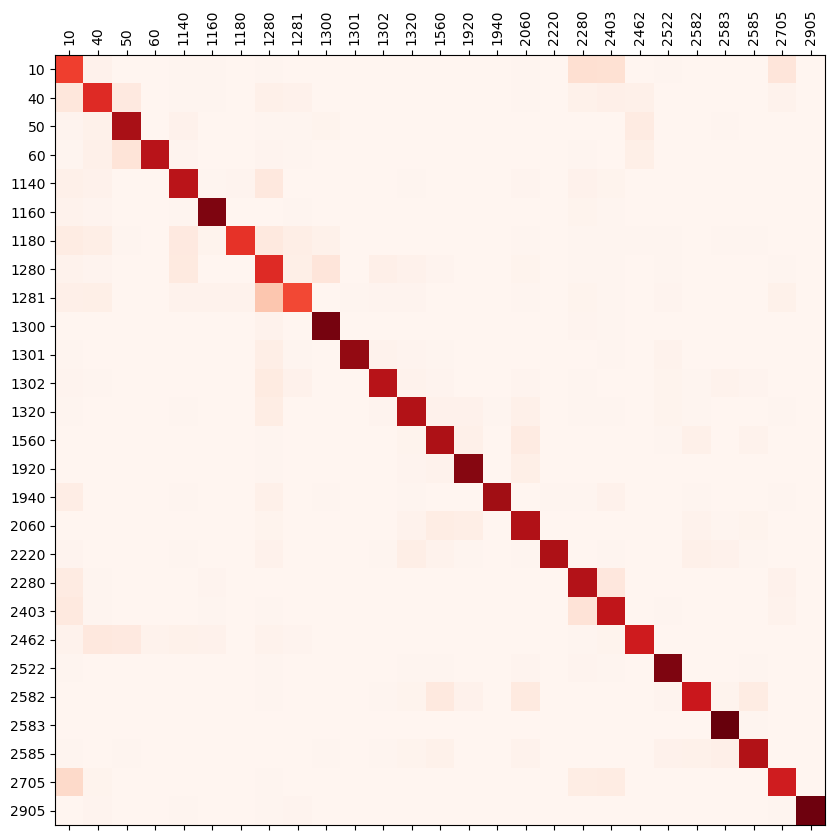

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [ ]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
vectorizer=text_clf.named_steps['tfidf']
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 3 to 18679
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3389 non-null   int64 
 1   designation     3389 non-null   object
 2   description     569 non-null    object
 3   productid       3389 non-null   int64 
 4   imageid         3389 non-null   int64 
 5   PAYS_LANGUE     3389 non-null   object
 6   design_descrip  3389 non-null   object
 7   phrases         3389 non-null   object
 8   prdtypecode     3389 non-null   int64 
 9   predict         3389 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 291.2+ KB


### Tableau des repartitions des **classes predites** pour chaque `classe réelle`

In [ ]:
for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.604380
2280    0.121168
2403    0.115328
2705    0.089051
40      0.021898
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.809933
2403    0.080229
10      0.057307
2705    0.021968
1160    0.010506
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.769524
2280    0.101905
10      0.069524
2705    0.019048
1160    0.007619
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.718287
10      0.144975
2403    0.052718
2280    0.049423
40      0.013180
Name: proportion, dtype: float64


### Les 10 mots ayant le **scores TF-IDF** les plus élévés et ceux des rangs de 76 à 80.   
Ces scores aident à identifier les mots qui sont importants dans un document particulier en tenant compte  
de leur fréquence dans ce document et de leur rareté dans l'ensemble du corpus.

In [ ]:
Words = vectorizer.transform(df_livres['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

              Total
lot       93.297337
tome      56.344146
livres    51.999364
01        40.179128
10        38.497605
12        32.783278
11        30.922111
france    30.095782
revue     29.677567
magazine  29.114804
              Total
piano      7.124548
24         7.036313
avril      6.973697
album      6.967048
intégrale  6.873213


### Les 20 mots ayant le **scores TF-IDF** les plus élévés .

In [ ]:
df_total_livres=df_words
words = vectorizer.get_feature_names_out()
for c in [10,2705,2280,2403]:
    X_words = vectorizer.transform(df_livres[df_livres['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_livres=df_total_livres.join(df_words_X)
df_total_livres.head(20)

,Total,10,2705,2280,2403
lot,93.297337,NaN,NaN,NaN,92.158471
tome,56.344146,11.650113,21.940619,NaN,21.325055
livres,51.999364,NaN,NaN,NaN,50.275812
01,40.179128,NaN,NaN,36.974804,NaN
10,38.497605,NaN,NaN,19.536979,16.409545
12,32.783278,NaN,NaN,19.277957,12.077328
11,30.922111,3.646027,NaN,20.438734,NaN
france,30.095782,3.912862,NaN,14.726065,9.712943
revue,29.677567,NaN,NaN,16.593297,11.865593
magazine,29.114804,NaN,NaN,20.411596,NaN


### Heatmap couleur Rouge foncée : fréquence très élévée
couleur Bleu foncée : fréquance très basse
couleur Blanche : NaN

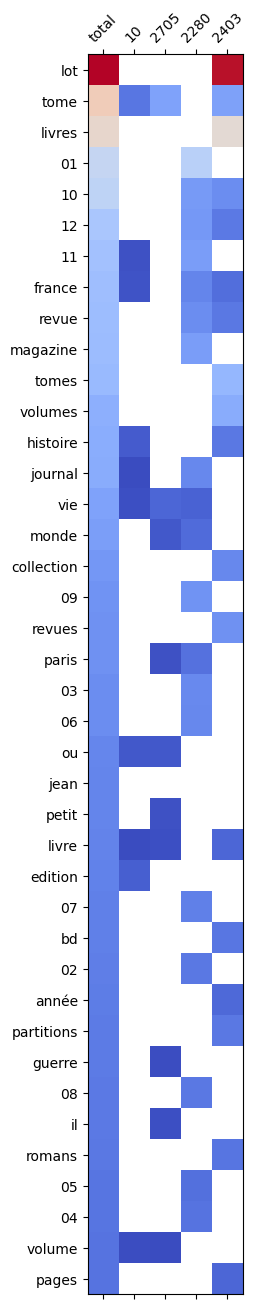

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(5),('total','10','2705','2280','2403'),rotation=45)
plt.yticks(range(40),df_total_livres.iloc[0:40].index,rotation=0)
plt.show()

## Etude des catégories 1280,1281

In [ ]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

### Tableau des repartitions des **classes predites** pour chaque `classe réelle`

In [ ]:
for c in [1280,1281]:
    print(c,'   ------   ', catdict[c] )
    print(df_jouets[df_jouets['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

1280    ------    jouets, peluches, poupees
predict
1280    0.668534
1300    0.089636
1140    0.061625
1281    0.035481
1302    0.031746
Name: proportion, dtype: float64
1281    ------    jeux de societe/cartes
predict
1281    0.575824
1280    0.210989
40      0.037363
10      0.030769
2705    0.024176
Name: proportion, dtype: float64


### Les 10 mots ayant le **scores TF-IDF** les plus élévés et ceux des rangs de 76 à 80.   
Ces scores aident à identifier les mots qui sont importants dans un document particulier en tenant compte  
de leur fréquence dans ce document et de leur rareté dans l'ensemble du corpus.

In [ ]:
Words = vectorizer.transform(df_jouets['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

             Total
enfants  45.267651
jouet    37.558010
peluche  35.140603
jouets   34.989406
toy      32.252619
doudou   30.234269
puzzle   27.056359
jeu      23.825432
bébé     21.655558
cadeau   21.282932
                  Total
développement  5.803189
boule          5.802947
simulé         5.781250
musique        5.724818
jouer          5.718962


### Les 20 mots ayant le **scores TF-IDF** les plus élévés .  

In [ ]:
df_total_jouets=df_words
words = vectorizer.get_feature_names_out()
for c in [1280,1281]:
    X_words = vectorizer.transform(df_jouets[df_jouets['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_jouets=df_total_jouets.join(df_words_X)
df_total_jouets.head(20)

,Total,1280,1281
enfants,45.267651,33.080509,12.187142
jouet,37.558010,29.292394,8.265616
peluche,35.140603,32.579356,NaN
jouets,34.989406,26.024941,8.964465
toy,32.252619,22.019574,10.233046
doudou,30.234269,30.234269,NaN
puzzle,27.056359,22.612416,4.443943
jeu,23.825432,NaN,19.169829
bébé,21.655558,14.665426,6.990132
cadeau,21.282932,15.821260,5.461672


###**Heatmap**
couleur Rouge foncée : fréquence très élévée  
couleur Bleu foncée : fréquance très basse  
couleur Blanche : NaN  

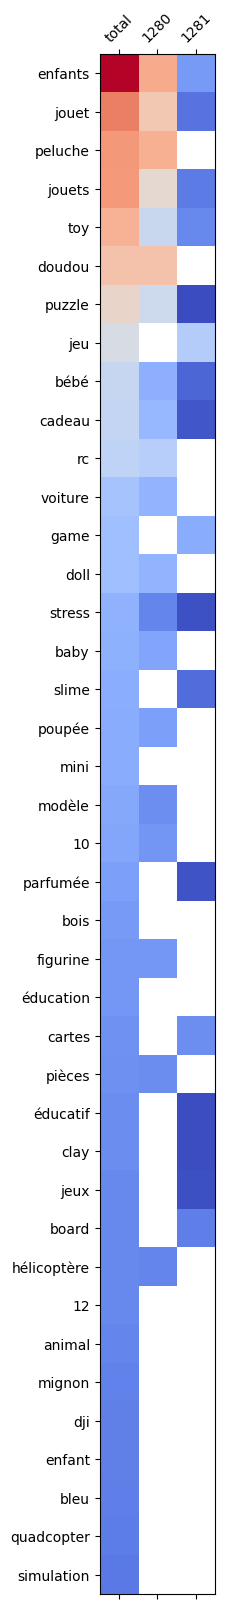

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_jouets.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(3),('total','1280','1281'),rotation=45)
plt.yticks(range(40),df_total_jouets.iloc[0:40].index,rotation=0)
plt.show()